# Packages Loading


In [269]:
%load_ext autoreload
%autoreload 2

from collections import defaultdict
from itertools import product
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
import yaml
from tqdm import tqdm

from analysis.dataset.june_dataset import JuNEDataset
from analysis.metrics.metrics_graph import GraphMetrics
from analysis.metrics.utils.graph_tools import dataframe_to_graphviz

sns.reset_orig()
plt.style.use('https://github.com/klieret/simple-science-style/raw/main/stylesheets/sss1.mplstyle')
plt.rcParams["font.family"] = "Times New Roman"


def read_config(config_path: Path = Path("data_config.yaml")) -> dict:
    with config_path.open("r") as stream:
        try:
            return yaml.safe_load(stream)
        except yaml.YAMLError:
            return {}


config = read_config()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read Data


In [270]:
df_hack = pd.read_csv(config.get("dataset_path"), index_col=0)
df_labels = pd.read_csv(config.get("label_mapping_path"), index_col=0)
df_hack = df_hack.merge(df_labels, on='action_id')

df_hack.head()


,action_id,time,session_id,kernel_id,notebook_name,event,cell_index,cell_num,cell_type,cell_source,cell_output,user_id,expert,cell_label
0,0,2023-05-06 10:32:26.282,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,save_notebook,NaN,NaN,NaN,"[\n {\n ""id"": ""35c0b3b694f84140846a21197ea...",NaN,student_7,False,NaN
1,1,2023-05-06 10:32:55.892,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,execute,35c0b3b694f84140846a21197ea62f68,0.0,code,from mining_extension import check_logging \nc...,NaN,student_7,False,helper_functions
2,2,2023-05-06 10:32:56.229,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,finished_execute,35c0b3b694f84140846a21197ea62f68,0.0,code,from mining_extension import check_logging \nc...,"[{""output_type"":""stream"",""size"":23}]",student_7,False,helper_functions
3,3,2023-05-06 10:32:58.048,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,execute,35c0b3b694f84140846a21197ea62f68,0.0,code,from mining_extension import check_logging \nc...,NaN,student_7,False,helper_functions
4,4,2023-05-06 10:32:58.429,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,finished_execute,35c0b3b694f84140846a21197ea62f68,0.0,code,from mining_extension import check_logging \nc...,"[{""output_type"":""stream"",""size"":23}]",student_7,False,helper_functions


In [271]:
june = JuNEDataset(df_hack)
june.prepare_dataset()
june.df.head()


,action_id,time,session_id,kernel_id,notebook_name,event,cell_index,cell_num,cell_type,cell_source,cell_output,user_id,expert,cell_label,task
0,0,2023-05-06 10:32:26.282,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,save_notebook,None,None,None,"[\n {\n ""id"": ""35c0b3b694f84140846a21197ea...",None,student_7,False,,task1
1,1,2023-05-06 10:32:55.892,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,execute,35c0b3b694f84140846a21197ea62f68,0.0,code,from mining_extension import check_logging \nc...,None,student_7,False,helper_functions,task1
2,2,2023-05-06 10:32:56.229,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,finished_execute,35c0b3b694f84140846a21197ea62f68,0.0,code,from mining_extension import check_logging \nc...,"[{""output_type"":""stream"",""size"":23}]",student_7,False,helper_functions,task1
3,3,2023-05-06 10:32:58.048,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,execute,35c0b3b694f84140846a21197ea62f68,0.0,code,from mining_extension import check_logging \nc...,None,student_7,False,helper_functions,task1
4,4,2023-05-06 10:32:58.429,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,finished_execute,35c0b3b694f84140846a21197ea62f68,0.0,code,from mining_extension import check_logging \nc...,"[{""output_type"":""stream"",""size"":23}]",student_7,False,helper_functions,task1


# Initialize Metrics Processor


In [272]:
processor = GraphMetrics()


# Metrics Calculation


In [273]:
grouped = june.df.groupby("kernel_id")
df_kernel = grouped.get_group(list(grouped.groups.keys())[0])
df_kernel.head()


,action_id,time,session_id,kernel_id,notebook_name,event,cell_index,cell_num,cell_type,cell_source,cell_output,user_id,expert,cell_label,task
1113,1113,2023-05-06 11:58:35.270,7215278a-b19d-477e-82df-9a03bb979fb6,0033f76c-6179-4fb4-a9ce-79112a52b51c,task1.ipynb,execute,e139884774504ae997d7e38e6be6da88,0.0,code,# # Do not forget to check if your notebook lo...,None,student_0,False,helper_functions,task1
1114,1114,2023-05-06 11:58:58.001,7215278a-b19d-477e-82df-9a03bb979fb6,0033f76c-6179-4fb4-a9ce-79112a52b51c,task1.ipynb,finished_execute,e139884774504ae997d7e38e6be6da88,0.0,code,# # Do not forget to check if your notebook lo...,"[{""output_type"":""stream"",""size"":23}]",student_0,False,helper_functions,task1
1115,1115,2023-05-06 11:58:58.174,7215278a-b19d-477e-82df-9a03bb979fb6,0033f76c-6179-4fb4-a9ce-79112a52b51c,task1.ipynb,save_notebook,None,None,None,"[\n {\n ""id"": ""e139884774504ae997d7e38e6be...",None,student_0,False,load_data,task1
1116,1116,2023-05-06 11:59:02.653,7215278a-b19d-477e-82df-9a03bb979fb6,0033f76c-6179-4fb4-a9ce-79112a52b51c,task1.ipynb,execute,a47800e62cbe40c1ad4003b2879f5f03,1.0,code,!pip install pandas\n,None,student_0,False,helper_functions,task1
1117,1117,2023-05-06 11:59:03.475,7215278a-b19d-477e-82df-9a03bb979fb6,0033f76c-6179-4fb4-a9ce-79112a52b51c,task1.ipynb,finished_execute,a47800e62cbe40c1ad4003b2879f5f03,2.0,code,!pip install pandas\n,"[{""output_type"":""stream"",""size"":649}]",student_0,False,helper_functions,task1


In [274]:
graph_metrics = processor.calculate_kernel_metrics(df_kernel)
graph_metrics.head()


,kernel_id,modularity,average_degree,average_clustering,nodes_count,edges_count
0,0033f76c-6179-4fb4-a9ce-79112a52b51c,0.283695,18.9,0.270952,20,189


In [275]:
graph_metrics = processor.calculate_metrics(june.df)
graph_metrics.head()


100%|██████████| 31/31 [00:21<00:00,  1.43it/s]


,kernel_id,modularity,average_degree,average_clustering,nodes_count,edges_count
0,0033f76c-6179-4fb4-a9ce-79112a52b51c,0.283695,18.900000,0.270952,20,189
0,033a2c63-4cfb-4cc5-9988-59c48a06eb23,0.580378,5.071429,0.127423,168,426
0,19160d7e-eb8e-4a81-9e92-e9d8335eee31,0.564548,10.238095,0.252116,42,215
0,232bcb48-7455-4109-9eeb-809649a6bedc,0.502743,12.985507,0.229112,69,448
0,29da7c56-5a69-485f-b181-a0a7199a559c,0.572181,7.943396,0.143793,106,421


In [276]:
df_tmp = june.df[['user_id', 'kernel_id', 'expert', 'task']] \
    .drop_duplicates(subset=['user_id', 'kernel_id', 'expert'], keep='last')

graph_metrics_merged = graph_metrics.merge(df_tmp, on='kernel_id')
graph_metrics_merged.head()


,kernel_id,modularity,average_degree,average_clustering,nodes_count,edges_count,user_id,expert,task
0,0033f76c-6179-4fb4-a9ce-79112a52b51c,0.283695,18.900000,0.270952,20,189,student_0,False,task1
1,033a2c63-4cfb-4cc5-9988-59c48a06eb23,0.580378,5.071429,0.127423,168,426,student_0,False,task1
2,19160d7e-eb8e-4a81-9e92-e9d8335eee31,0.564548,10.238095,0.252116,42,215,expert_5,True,task1
3,232bcb48-7455-4109-9eeb-809649a6bedc,0.502743,12.985507,0.229112,69,448,expert_1,True,task2
4,29da7c56-5a69-485f-b181-a0a7199a559c,0.572181,7.943396,0.143793,106,421,student_2,False,task1


In [277]:
metrics = [
    'average_degree', 'modularity', 'average_clustering',
    'nodes_count', 'edges_count'
]


In [278]:
graph_table = graph_metrics_merged.groupby(['task', 'expert'])[metrics].mean().round(2).applymap('{:.2f}'.format)
graph_table


/var/folders/3y/nyxrc7xj5fsfcj6kx385np600000gp/T/ipykernel_50084/136587702.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  graph_table = graph_metrics_merged.groupby(['task', 'expert'])[metrics].mean().round(2).applymap('{:.2f}'.format)


average_degree modularity average_clustering nodes_count  \
task  expert                                                            
task1 False           11.58       0.52               0.20       71.79   
      True            12.23       0.53               0.20       45.80   
task2 False           11.08       0.47               0.23       46.83   
      True             8.72       0.55               0.23       79.83   

             edges_count  
task  expert              
task1 False       325.79  
      True        242.60  
task2 False       227.67  
      True        344.50

In [279]:
pretty_lang = {'task1': 'DS', 'task2': 'ML', np.NaN: 'All',
               False: 'Student', True: 'Professional'}

new_names = [
    'Task', 'Level of expertise', 'Modularity',
    'Average degree', 'Average clustering coef.',
    "Number of nodes", "Number of edges"
]
graph_table_prettify = graph_table.reset_index()
graph_table_prettify.columns = new_names
graph_table_prettify = graph_table_prettify.replace(pretty_lang) \
    .set_index(['Task', 'Level of expertise']).astype(float) \
    .map(lambda el: str.format("{:0_.2f}", el).replace('.', ',').replace('_', '.'))

graph_table_prettify


Modularity Average degree Average clustering coef.  \
Task Level of expertise                                                      
DS   Student                 11,58           0,52                     0,20   
     Professional            12,23           0,53                     0,20   
ML   Student                 11,08           0,47                     0,23   
     Professional             8,72           0,55                     0,23   

                        Number of nodes Number of edges  
Task Level of expertise                                  
DS   Student                      71,79          325,79  
     Professional                 45,80          242,60  
ML   Student                      46,83          227,67  
     Professional                 79,83          344,50

In [280]:
print(graph_table_prettify.to_latex(escape=True))


\begin{tabular}{lllllll}
\toprule
 &  & Modularity & Average degree & Average clustering coef. & Number of nodes & Number of edges \\
Task & Level of expertise &  &  &  &  &  \\
\midrule
\multirow[t]{2}{*}{DS} & Student & 11,58 & 0,52 & 0,20 & 71,79 & 325,79 \\
 & Professional & 12,23 & 0,53 & 0,20 & 45,80 & 242,60 \\
\cline{1-7}
\multirow[t]{2}{*}{ML} & Student & 11,08 & 0,47 & 0,23 & 46,83 & 227,67 \\
 & Professional & 8,72 & 0,55 & 0,23 & 79,83 & 344,50 \\
\cline{1-7}
\bottomrule
\end{tabular}


In [281]:
graph_metrics_merged.anova(dv="modularity", between=["expert", "task"]).round(3)


,Source,SS,DF,MS,F,p-unc,np2
0,expert,0.013,1.0,0.013,1.783,0.193,0.062
1,task,0.004,1.0,0.004,0.560,0.461,0.020
2,expert * task,0.007,1.0,0.007,1.061,0.312,0.038
3,Residual,0.190,27.0,0.007,NaN,NaN,NaN


In [282]:
graph_metrics_merged.anova(dv="average_degree", between=["expert", "task"]).round(3)


,Source,SS,DF,MS,F,p-unc,np2
0,expert,3.293,1.0,3.293,0.055,0.816,0.002
1,task,19.671,1.0,19.671,0.328,0.571,0.012
2,expert * task,15.003,1.0,15.003,0.251,0.621,0.009
3,Residual,1616.855,27.0,59.884,NaN,NaN,NaN


In [283]:
graph_metrics_merged.anova(dv="average_clustering", between=["expert", "task"]).round(3)


,Source,SS,DF,MS,F,p-unc,np2
0,expert,0.000,1.0,0.000,0.024,0.877,0.001
1,task,0.007,1.0,0.007,1.161,0.291,0.041
2,expert * task,0.000,1.0,0.000,0.013,0.910,0.000
3,Residual,0.167,27.0,0.006,NaN,NaN,NaN



# Display graph

In [284]:
graphs = {}
grouped = june.df.groupby(['user_id', 'kernel_id'])

for (user_id, kernel_id), g in tqdm(grouped):
    df_kernel = g
    gv = dataframe_to_graphviz(df_kernel)
    gv.attr(rankdir='LR', size='100,100')
    gv.render(directory='figures/graphs', format='pdf', filename=f"graph_{user_id}", cleanup=True).replace('\\', '/')
    graphs[(user_id, kernel_id)] = gv



100%|██████████| 31/31 [00:05<00:00,  5.37it/s]


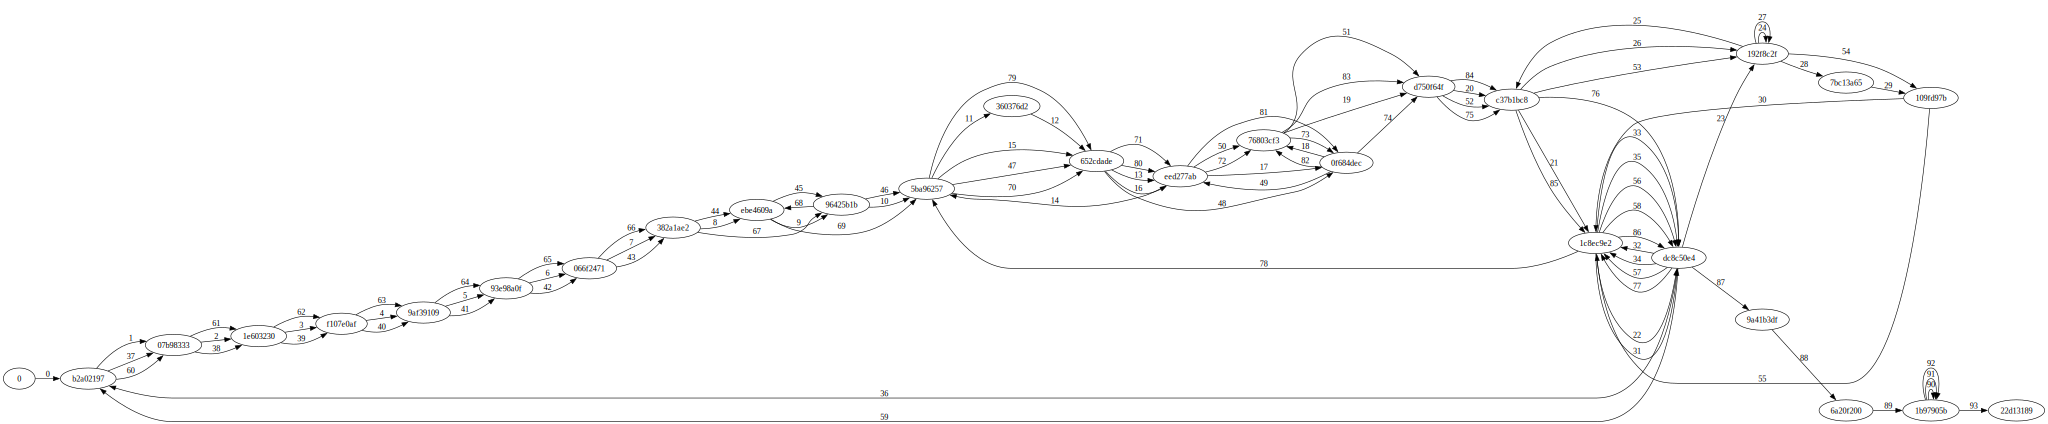

In [285]:
g = list(graphs.values())[3]
g


In [286]:
grouped = june.df.groupby("kernel_id")

load = True
if not load:
    evolution_dfs = [
        pd.concat(
            [processor.calculate_metrics(g.iloc[:i], progress=False)
             for i in tqdm(range(1, g.shape[0], 10))], axis=0, ignore_index=True
        ).reset_index().rename({"index": "state_num"}, axis=1)
        for kernel_id, g in grouped
    ]

    all_evolutions = pd.concat(evolution_dfs, axis=0, ignore_index=True)
    all_evolutions.to_csv("../data/graph_evolution.csv")
else:
    all_evolutions = pd.read_csv(config.get("graph_evolution_path"), index_col=0)

all_evolutions.head()


,state_num,kernel_id,modularity,average_degree,average_clustering,nodes_count,edges_count
0,0,0033f76c-6179-4fb4-a9ce-79112a52b51c,0.000000,1.000000,0.0,2,1
1,1,0033f76c-6179-4fb4-a9ce-79112a52b51c,0.300000,1.666667,0.0,6,5
2,2,0033f76c-6179-4fb4-a9ce-79112a52b51c,0.401235,2.000000,0.0,9,9
3,3,0033f76c-6179-4fb4-a9ce-79112a52b51c,0.488166,2.000000,0.0,13,13
4,4,0033f76c-6179-4fb4-a9ce-79112a52b51c,0.495556,2.428571,0.0,14,17


In [287]:
def continuous_transform(x, y, size: int = 1000, normalize: bool = True) -> tuple[np.ndarray, np.ndarray]:
    x_max = 1 if normalize else np.max(x)
    xp = np.linspace(0, x_max, size)
    x = np.linspace(0, x_max, len(y))
    y = np.array(y)

    y[np.isnan(y)] = 0
    y = np.interp(xp, x, y) + 1e-5
    return xp, y


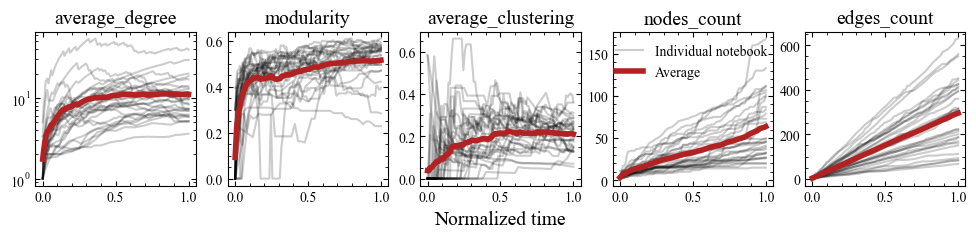

In [288]:
fig, axs = plt.subplots(1, 5, figsize=(12, 2))

for i, metric in enumerate(metrics):
    ax = axs[i]
    curves = []
    for kernel_id, g in all_evolutions.groupby("kernel_id"):
        x, y = continuous_transform(
            np.linspace(0, 1, g[metric].shape[0]),
            g[metric].astype('float')
        )
        curves.append(y)
        ax.plot(x, y, alpha=0.2, color='k')

    ax.set_title(metric, fontsize=14)
    ax.plot(x, np.sum(curves, axis=0) / len(curves), color='firebrick', lw=4)

axs[-1].lines[-2].set_label(s="Individual notebook")
axs[-1].lines[-1].set_label(s="Average")
legend = plt.legend(bbox_to_anchor=(-0.16, 1), fontsize=10)

axs[2].set_xlabel("Normalized time", fontsize=14)
axs[0].set_yscale("log")
plt.savefig("figures/evolution/graph_metrics.pdf", dpi=300, bbox_inches='tight')
plt.show()


In [289]:
df_tmp = june.df[['user_id', 'kernel_id', 'expert', 'task']] \
    .drop_duplicates(subset=['user_id', 'kernel_id', 'expert'], keep='last')

graph_evolution_merged = all_evolutions.merge(df_tmp, on='kernel_id')
graph_evolution_merged.head()


,state_num,kernel_id,modularity,average_degree,average_clustering,nodes_count,edges_count,user_id,expert,task
0,0,0033f76c-6179-4fb4-a9ce-79112a52b51c,0.000000,1.000000,0.0,2,1,student_0,False,task1
1,1,0033f76c-6179-4fb4-a9ce-79112a52b51c,0.300000,1.666667,0.0,6,5,student_0,False,task1
2,2,0033f76c-6179-4fb4-a9ce-79112a52b51c,0.401235,2.000000,0.0,9,9,student_0,False,task1
3,3,0033f76c-6179-4fb4-a9ce-79112a52b51c,0.488166,2.000000,0.0,13,13,student_0,False,task1
4,4,0033f76c-6179-4fb4-a9ce-79112a52b51c,0.495556,2.428571,0.0,14,17,student_0,False,task1


In [290]:
df_tmp = graph_evolution_merged
max_values = df_tmp.groupby('kernel_id')['state_num'].transform('max')
df_tmp['normalized_state'] = df_tmp['state_num'] / max_values

df_corr = df_tmp.groupby(['task', 'expert'])[['normalized_state', *metrics]].corr(method='spearman')
indices = [i for i in df_corr.index if i[-1] == 'normalized_state']
df_corr[metrics] = df_corr[metrics]

table = df_corr.loc[indices][metrics].droplevel(2)
table.round(3)


average_degree  modularity  average_clustering  nodes_count  \
task  expert                                                                
task1 False            0.299       0.449               0.334        0.712   
      True             0.518       0.660               0.323        0.844   
task2 False            0.415       0.387               0.456        0.732   
      True             0.625       0.687               0.419        0.849   

              edges_count  
task  expert               
task1 False         0.828  
      True          0.931  
task2 False         0.778  
      True          0.865

In [291]:
print(table.round(2).applymap('{:.2f}'.format).to_latex(escape=True, multirow=True))


\begin{tabular}{lllllll}
\toprule
 &  & average\_degree & modularity & average\_clustering & nodes\_count & edges\_count \\
task & expert &  &  &  &  &  \\
\midrule
\multirow[t]{2}{*}{task1} & False & 0.30 & 0.45 & 0.33 & 0.71 & 0.83 \\
 & True & 0.52 & 0.66 & 0.32 & 0.84 & 0.93 \\
\cline{1-7}
\multirow[t]{2}{*}{task2} & False & 0.41 & 0.39 & 0.46 & 0.73 & 0.78 \\
 & True & 0.62 & 0.69 & 0.42 & 0.85 & 0.86 \\
\cline{1-7}
\bottomrule
\end{tabular}


/var/folders/3y/nyxrc7xj5fsfcj6kx385np600000gp/T/ipykernel_50084/4147803597.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  print(table.round(2).applymap('{:.2f}'.format).to_latex(escape=True, multirow=True))


In [292]:
alpha = 0.05
for task in ['task1', 'task2']:
    for expert in [True, False]:
        for metric in metrics:
            df_sample = df_tmp[(df_tmp.task == task) & (df_tmp.expert == expert)][['normalized_state', metric]]
            cor = pg.corr(
                df_sample.normalized_state, df_sample[metric].astype('float'), 
                method='spearman'
            )
            if cor['p-val'].iloc[0] > alpha:
                print(metric, task, expert, cor['r'].iloc[0].round(2), cor['p-val'].iloc[0].round(2))


In [293]:
pairs = sorted(list(product(['task1', 'task2'], [True, False])))
colors = ["navy", 'firebrick', 'navy', 'firebrick']
mapping = {pairs[i]: colors[i] for i in range(4)}


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


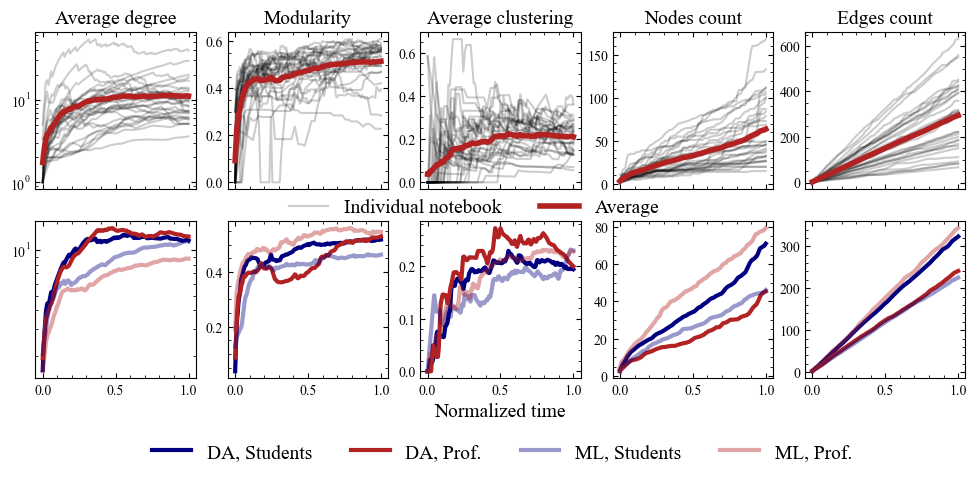

In [294]:
fig, axs = plt.subplots(2, 5, figsize=(12, 4.5))

for i, metric in enumerate(metrics):
    ax = axs[0][i]
    curves = []
    for kernel_id, g in all_evolutions.groupby("kernel_id"):
        x, y = continuous_transform(
            np.linspace(0, 1, g[metric].shape[0]),
            g[metric].astype('float')
        )
        curves.append(y)
        ax.plot(x, y, alpha=0.2, color='k')

    ax.set_title(metric.replace("_", " ").capitalize(), fontsize=14)
    ax.set_xticklabels([])
    ax.plot(x, np.sum(curves, axis=0) / len(curves), color='firebrick', lw=4)

axs[0][-1].lines[-2].set_label(s="Individual notebook")
axs[0][-1].lines[-1].set_label(s="Average")
legend = plt.legend(bbox_to_anchor=(-0.16, 1), fontsize=10)

axs[1][2].set_xlabel("Normalized time", fontsize=14)
axs[0][0].set_yscale("log")

metric_curves = {}

for i, metric in enumerate(metrics):
    ax = axs[1][i]
    for (task, expert) in pairs:
        curves = []
        for kernel_id, g in graph_evolution_merged.groupby(['task', 'expert']).get_group((task, expert)).groupby(
                "kernel_id"):
            x, y = continuous_transform(
                np.linspace(0, 1, g[metric].shape[0]),
                g[metric].astype('float')
            )
            if metric == 'average_clustering' and y[0] > 0.2:
                continue
            curves.append(y)

        y = np.sum(curves, axis=0) / len(curves)
        f = np.poly1d(np.polyfit(x, y, 4))
        alpha = 1 if task == 'task1' else 0.4
        ls = '-'  # if task == "task1" else (5, (3, 3))
        label = f"{'DA' if task == 'task1' else 'ML'}, {'Prof.' if expert else 'Students'}"
        ax.plot(x, y, label=label, color=mapping[(task, expert)], lw=3, ls=ls, alpha=alpha)

axs[0][0].lines[0].set_label("Individual notebook")
axs[0][0].lines[-1].set_label("Average")

axs[0][0].legend(ncol=2, bbox_to_anchor=(4, 0.05), fontsize=14)

axs[1][0].legend(ncol=4, bbox_to_anchor=(5.2, -0.3), fontsize=14)
axs[1][0].set_yscale("log")

plt.savefig("figures/evolution/graph_metrics_extended.pdf", dpi=300, bbox_inches='tight')
plt.show()


In [295]:
def calculate_ratio(df_subset):
    execute_events = df_subset[df_subset['event'] == 'execute']
    hanging_cells_counts = execute_events['cell_index'].value_counts().value_counts().get(1, 0)
    total_executed_cells = execute_events['cell_index'].nunique()
    ratio = hanging_cells_counts / total_executed_cells
    return ratio


In [296]:
grouped = june.df.groupby('kernel_id')
result = grouped.apply(calculate_ratio).reset_index(name='ratio')

print(np.around(result.ratio.mean() * 100, 1), '%')


29.8 %


In [297]:
grouped = june.df.groupby(['expert', 'kernel_id'])
result = grouped.apply(calculate_ratio).reset_index(name='ratio')
result.groupby("expert").ratio.mean().mul(100).round(1).astype(str).add(' %').to_frame()


,ratio
expert,
False,31.6 %
True,26.5 %


In [298]:
grouped = june.df.groupby(['task', 'kernel_id'])
result = grouped.apply(calculate_ratio).reset_index(name='ratio')
result.groupby("task").ratio.mean().mul(100).round(1).astype(str).add(' %').to_frame()


,ratio
task,
task1,33.1 %
task2,24.6 %


In [299]:
threshold = 0.05

experimental_ratios = (
    june.df[june.df['event'] == 'execute'].groupby('kernel_id')
    .apply(lambda group: group['cell_index'].value_counts(sort=True))
    .loc[lambda t: t > 1]
    .groupby('kernel_id')
    .apply(
        lambda frequencies: (
                frequencies
                .head(int(np.ceil(frequencies.size * threshold)))
                .sum() / frequencies.sum()
        )
    )
)

print((experimental_ratios.mean() * 100).round(), '%')


24.0 %


In [300]:
def calculate_counts(df_kernel):
    cells = set()
    d = defaultdict(int)
    previous_idx = None

    for current_idx in df_kernel.cell_index:
        if current_idx not in cells:
            d["newly_created"] += 1
        elif previous_idx == current_idx:
            d['re_execute_current'] += 1
        else:
            d["already_existing"] += 1

        cells.add(current_idx)
        previous_idx = current_idx

    total = sum(d.values())
    return {k: v / total for k, v in d.items()}


In [301]:
execute_events = june.df[june.df['event'] == 'execute']
dict_list = [calculate_counts(df_kernel) for _, df_kernel in execute_events.groupby("kernel_id")]
pd.DataFrame(dict_list).mean().round(2).to_frame(name='probability')


,probability
newly_created,0.23
re_execute_current,0.36
already_existing,0.40
